In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from datetime import timedelta

warnings.filterwarnings("ignore")

In [2]:
def parser(s):
    return datetime.strptime(s, "%Y-%m")

In [3]:
df = pd.read_csv('AirPassengers.csv', parse_dates=[0], index_col= 0, date_parser=parser)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
# it determines M D or Y in steps automaticaly
df = df.asfreq(pd.infer_freq(df.index))

In [5]:
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<Axes: xlabel='Month'>

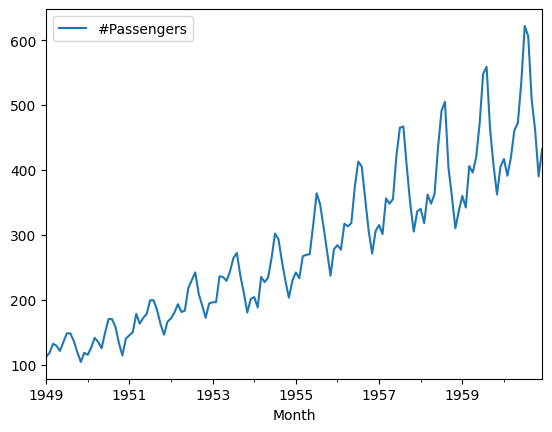

In [6]:
df.plot()

We can clearly see, that we have seasonality in our data

# Remove trend

In [7]:
diff_one = df.diff()[1:]

<Axes: xlabel='Month'>

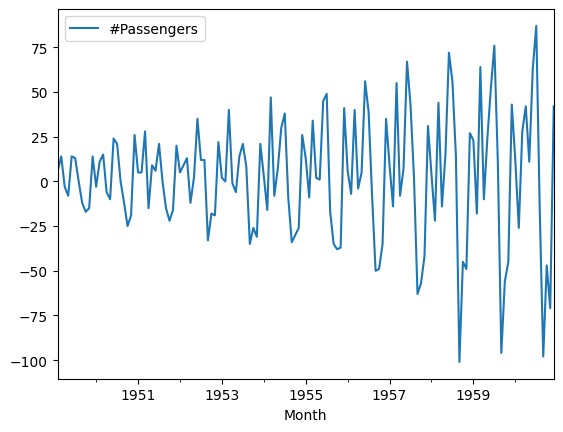

In [8]:
diff_one.plot()

In [9]:
adf_test = adfuller(diff_one)
print(adf_test[1])

0.05421329028382478


0.054 ist close enough to 0.05

# ACF

<BarContainer object of 20 artists>

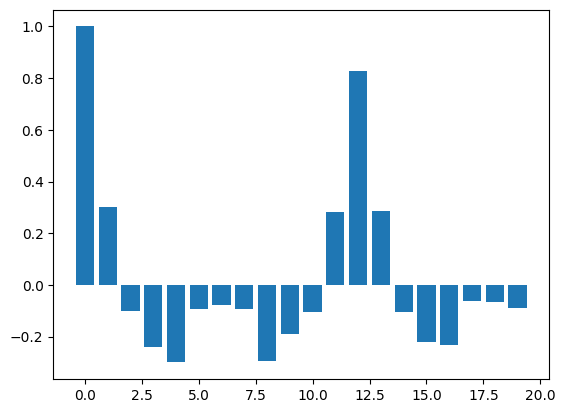

In [10]:
acf_vals = acf(diff_one)
num_lags = 20
plt.bar(range(num_lags),acf_vals[:num_lags])

Strong spike on lag 12, so based on this info we include in our model Seasonal MA with lag 1(12 month)

# PACF

<BarContainer object of 20 artists>

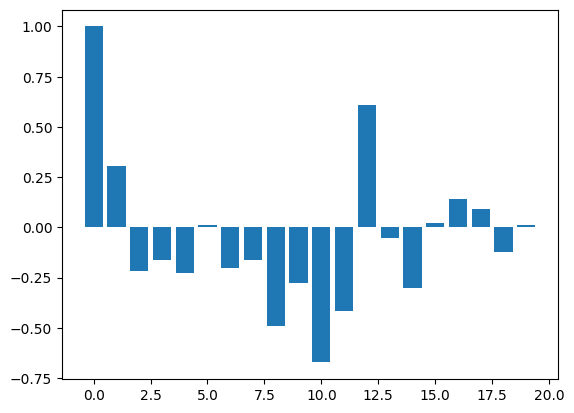

In [11]:
pacf_vals = pacf(diff_one)
num_lags = 20
plt.bar(range(num_lags),pacf_vals[:num_lags])

Based on PACF we can see strong spikes on lag 10 and 12, so we try to use both of them in Seasonal AR part of our model

# Train&test split

In [12]:
train_end = datetime(1959,12,1)
test_end = datetime(1960,12,1)
train_data = df[:train_end]
test_data = df[train_end + timedelta(days=1):test_end]

In [13]:
test_data

,#Passengers
Month,
1960-01-01,417
1960-02-01,391
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508


# Fit the SARIMA Model

In [14]:
# Try to fit MA 12 and AR 12
my_order = (0,1,0)
my_seasonal_order = (1,0,1,12)
# define the model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [15]:
# fit the model
model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50131D+01    |proj g|=  2.18994D+01

At iterate    5    f=  3.95240D+00    |proj g|=  1.33969D-01

At iterate   10    f=  3.86057D+00    |proj g|=  5.53662D-03

At iterate   15    f=  3.85952D+00    |proj g|=  1.90826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     18      1     0     0   3.356D-06   3.860D+00
  F =   3.8595188144535415     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [16]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          #Passengers   No. Observations:                  132
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -509.456
Date:                              Sun, 17 Nov 2024   AIC                           1024.913
Time:                                      08:32:13   BIC                           1033.539
Sample:                                  01-01-1949   HQIC                          1028.418
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9614      0.026     36.480      0.000       0.910       1.013
ma.S.L12      -0.0986      0.100     -0.987      0.324      -0.294       0.097
sigma2       112.2820     13.609      8.251      0.000      85.610     138.954
===================================================================================
Ljung-Box (L1) (Q):                   3.87   Jarque-Bera (JB):                 7.62
Prob(Q):                              0.05   Prob(JB):                         0.02
Heteroskedasticity (H):               2.17   Skew:                            -0.14
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

P value in MA strongly exceeds acceptable values, but when it is included in the model accuracy becomes higher and more stable, both on short-term forecast, and on one-year forecast. Therefore, i decided to include it in the model

# Forcast for the next 12 months 

In [17]:
test_data = test_data['#Passengers']

In [18]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

In [19]:
predictions.head()

Month
1960-01-01    425.267076
1960-02-01    407.740841
1960-03-01    467.202204
1960-04-01    457.312831
1960-05-01    479.359732
Freq: MS, Name: predicted_mean, dtype: float64

In [20]:
residuals.head()

Month
1960-01-01    -8.267076
1960-02-01   -16.740841
1960-03-01   -48.202204
1960-04-01     3.687169
1960-05-01    -7.359732
Freq: MS, dtype: float64

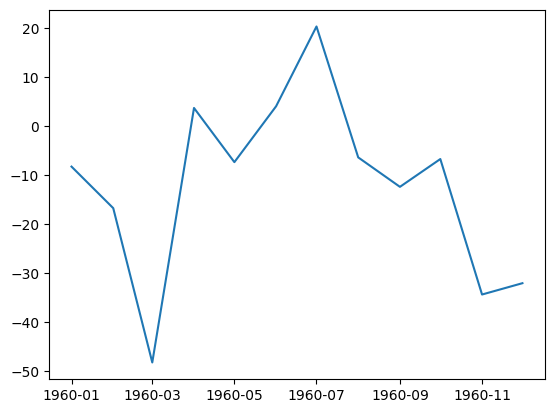

In [21]:
plt.plot(residuals)

Text(0, 0.5, 'Passengers')

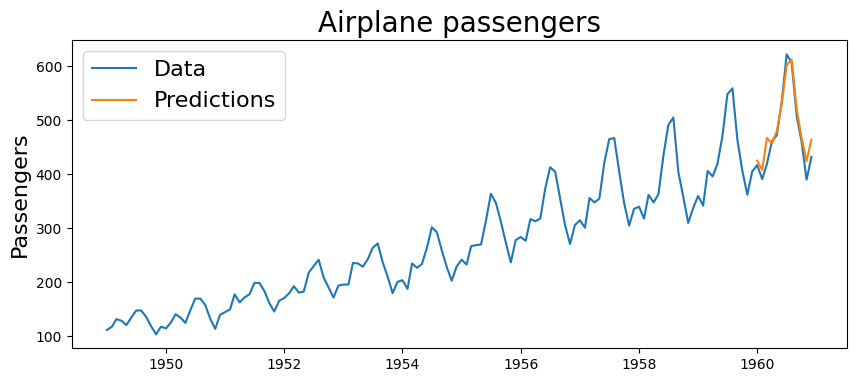

In [22]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Airplane passengers', fontsize=20)
plt.ylabel('Passengers', fontsize=16)

In [23]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0378


Accuracy when forcast next 12 months is 96.22%

# Rolling forcast

In [24]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = df[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50131D+01    |proj g|=  2.18994D+01

At iterate    5    f=  3.95240D+00    |proj g|=  1.33969D-01

At iterate   10    f=  3.86057D+00    |proj g|=  5.53662D-03

At iterate   15    f=  3.85952D+00    |proj g|=  1.90826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     18      1     0     0   3.356D-06   3.860D+00
  F =   3.8595188144535415     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.85545D+00    |proj g|=  2.39174D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     18      1     0     0   3.596D-06   3.855D+00
  F =   3.8554458459764991     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54359D+01    |proj g|=  2.21265D+01

At iterate    5    f=  3.97403D+00    |proj g|=  1.31050D-01

At iterate   10    f=  3.88335D+00    |proj g|=  9.84021D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.01338D+00    |proj g|=  8.73576D-02

At iterate   10    f=  3.95444D+00    |proj g|=  4.51898D-03

At iterate   15    f=  3.95325D+00    |proj g|=  1.50197D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     18      1     0     0   1.017D-07   3.953D+00
  F =   3.9532462892656950     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21855D+01    |proj g|=  1.66703D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     18      1     0     0   8.955D-07   3.957D+00
  F =   3.9565503741199901     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21245D+01    |proj g|=  1.65491D+01

At iterate    5    f=  4.03191D+00    |proj g|=  8.99564D-02

At iterate   10    f=  3.97173D+00    |proj g|=  5.12728D-03

At iterate   15    f=  3.97031D+00    |proj g|=  4.93232D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30073D+01    |proj g|=  1.85212D+01

At iterate    5    f=  4.02998D+00    |proj g|=  1.00047D-01

At iterate   10    f=  3.96564D+00    |proj g|=  5.38110D-03

At iterate   15    f=  3.96411D+00    |proj g|=  2.73979D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     17      1     0     0   5.153D-06   3.964D+00
  F =   3.9641061449564368     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

In [25]:
rolling_residuals = test_data - rolling_predictions

In [26]:
rolling_residuals

Month
1960-01-01    -8.267076
1960-02-01    -8.449383
1960-03-01   -31.300304
1960-04-01    51.938791
1960-05-01   -10.471941
1960-06-01    11.463137
1960-07-01    18.124504
1960-08-01   -26.595933
1960-09-01    -7.082413
1960-10-01     4.979369
1960-11-01   -27.943138
1960-12-01     3.111548
Freq: MS, Name: #Passengers, dtype: float64

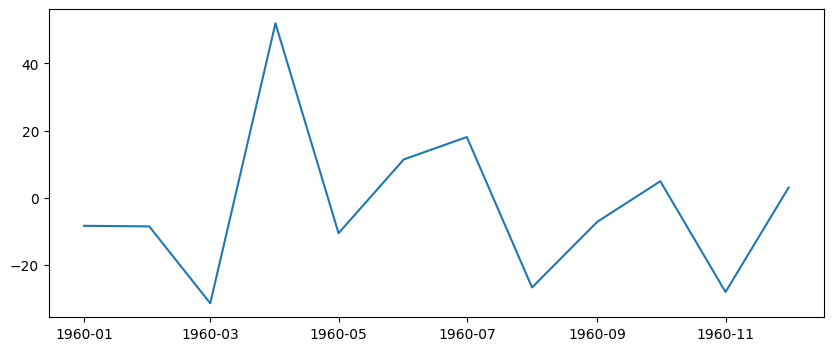

In [27]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)

Text(0, 0.5, 'Passengers')

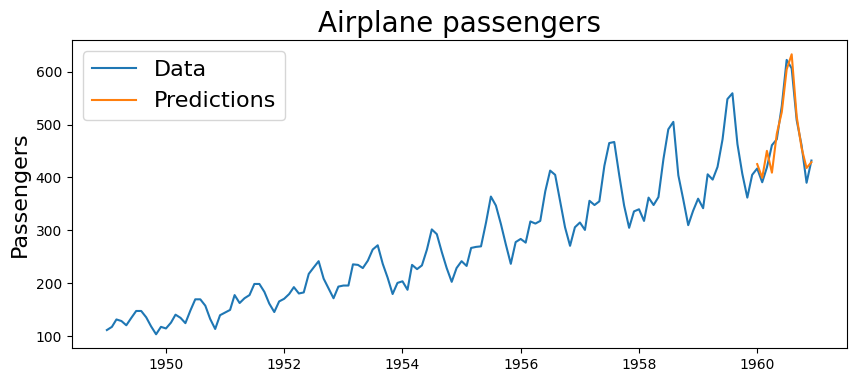

In [28]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Airplane passengers', fontsize=20)
plt.ylabel('Passengers', fontsize=16)

In [29]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0374


# Final accuracy is 96,626%!